In [62]:
#Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

import seaborn as sns


In [63]:
#To remove warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [64]:
#seaborn configuration
sns.set(rc={'figure.figsize':(10,5)}) 
sns.set_style('white')
sns.set_palette ("Set3")
#sns.set(rc={'figure.figsize':(11.7,8.27)})



## Load data

In [65]:
#file = "data/old/combined_dataframe.csv"
#df = pd.read_csv(file, sep = '\t')  

In [66]:
df_2019 = pd.read_csv("data/2019.csv", sep = '\t')  
df_2020 = pd.read_csv("data/2020.csv", sep = '\t')  
#df_2021_1 = pd.read_csv("data/2021-1.csv", sep = '\t')  
df_2021 = pd.read_csv("data/2021.csv", sep = '\t')  
df_2022 = pd.read_csv("data/2022.csv", sep = '\t')  

In [67]:
df = pd.concat([df_2019, df_2020, df_2021, df_2022], ignore_index=True)

### Number of races 

In [68]:
print("Number rows dataframe: ")
print(len(df))

Number rows dataframe: 
82523


## Rainy races
Races with rain, i.e. those in which intermediate or wet tires are used, are eliminated. 

### Plot

Text(0.5, 0, 'Years')

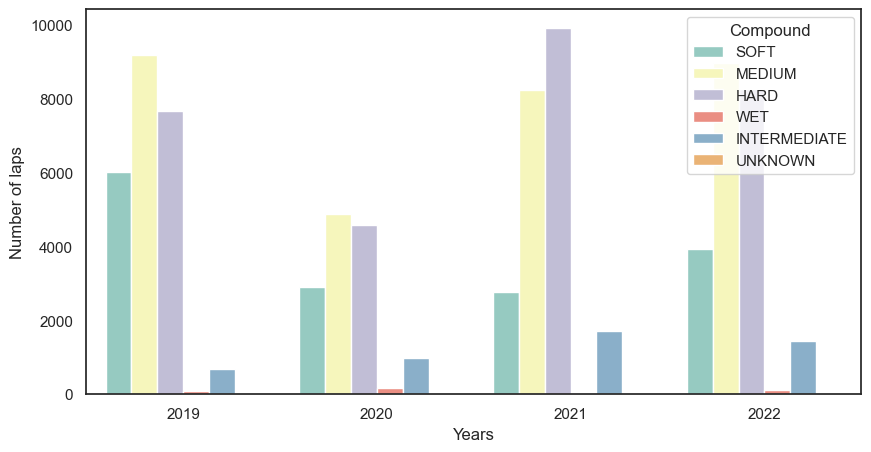

In [69]:
value_counts = df.groupby('Year')['Compound'].value_counts()
all_values = pd.MultiIndex.from_product([df['Year'].unique(), df['Compound'].unique()])
value_counts = value_counts.reindex(all_values, fill_value=0)

value_counts = value_counts.reset_index()
value_counts.columns = ['Year', 'Compound', "Value"]

# Set y-label to "number of laps"
plot = sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts)
plot.set_ylabel('Number of laps')
plot.set_xlabel('Years')

#sns.barplot(x='Year', y='Value', hue='Compound', data=value_counts,  palette={'SOFT':'r', 'MEDIUM':'y', 'HARD':'grey','INTERMEDIATE':'g', 'WET':'b'})



### Deleted 

In [70]:
#Initialized in 1, because I have removed by hand spa in 2021 already gave an error 
initial_races = 1
rain_races= 1 
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        initial_races+=1
        val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]
        #If in that race any driver uses Intermediate or wet tyres, delete the all the sace
        if ('INTERMEDIATE' in val['Compound'].values or 'WET' in val['Compound'].values):
            rain_races +=1
            df = df.drop(val.index)

print("Total races in the DataSet: " + str(initial_races))
print("Number of races that have been eliminated due to rain: " + str(rain_races))

Total races in the DataSet: 78
Number of races that have been eliminated due to rain: 13


## Retired or more than 4 stops 
Drivers who have not finished, or have finished lapped >2 lap are eliminated \\
Those who have more than 4 stops are also eliminated, this is due to some reason during the race, even if they have not retired.  \\
It may happen that these coincide with those of +2 laps or more, but in the chart they are counted separately. 


In [71]:
list_remove = pd.DataFrame()
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
            if ('Finished' != val["ResultStatus"].iloc[0] and '+1 Lap' != val["ResultStatus"].iloc[0] and '+2 Lap' != val["ResultStatus"].iloc[0]):
                #print(val["ResultStatus"].iloc[0])
                list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': val["ResultStatus"].iloc[0]}, ignore_index=True)
                df = df.drop(val.index)
            elif val["NumberPitStops"].iloc[-1] >4:  
                list_remove = list_remove.append({'year': year, 'driver': driver, 'problem': "+4 pit stops"}, ignore_index=True)
                df = df.drop(val.index)


### Plot

Text(0.5, 0, 'Reason for deleted')

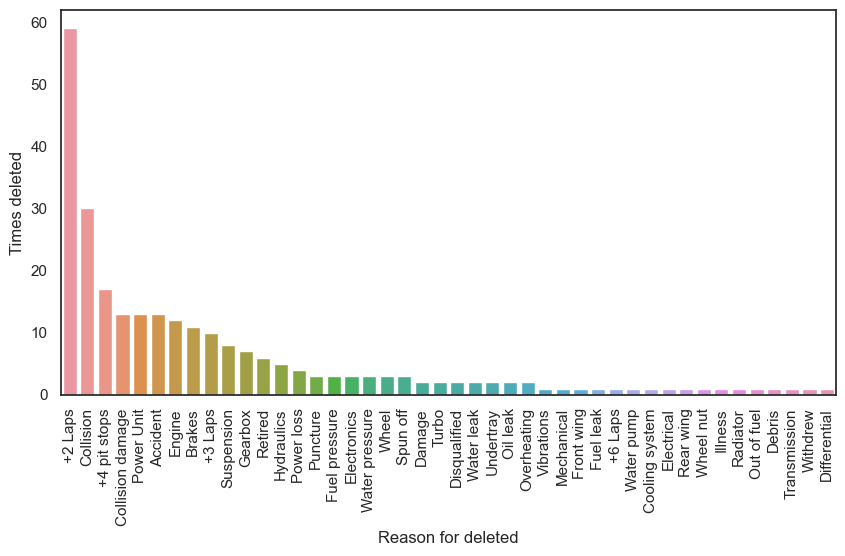

In [72]:
value_counts = list_remove["problem"].value_counts()

ax = sns.barplot(x=value_counts.index, y=value_counts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Times deleted')
ax.set_xlabel('Reason for deleted')

## Null values

In [73]:
null_cols = df.columns[df.isnull().any()]
print(null_cols)

Index(['QualyPosition', 'DriverStandings', 'DriverAhead', 'DriverBehind'], dtype='object')


### Qualy Position and GridPosition

In [74]:
for year in df['Year'].unique():
    for raceNumber in df[df['Year'] == year]['RaceNumber'].unique():
        for driver in df[(df['Year'] == year) & (df['RaceNumber'] == raceNumber)]["Driver"].unique():
            val = df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver)]
            if ( np.isnan(val["QualyPosition"].iloc[0])):
                df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "QualyPosition"] = val["Position"].iloc[0]
            if ( val["GridPosition"].iloc[0] == 0):
                df.loc[(df['Year'] == year) & (df['RaceNumber'] == raceNumber) & (df['Driver'] == driver), "GridPosition"] = val["Position"].iloc[0]

### DriverStandings

In [75]:
df['DriverStandings'] = df['DriverStandings'].fillna(0)

### DriverAhead and DriverBehind

In [76]:
df['DriverAhead'] = df['DriverAhead'].fillna('NaN')
df['DriverBehind'] = df['DriverBehind'].fillna('NaN')

In [77]:
df.to_csv('data/combined_dataframe.csv', index=False, header=True, sep ='\t' )

## Final number laps

In [79]:
print("Number rows dataframe after preprocesing: ")
print(len(df))

Number rows dataframe after preprocesing: 
60044
